# Lab 2: Neural Machine Translation in the wild

Baseline solution BLEU score is quite low. Try to achieve at least __24__ BLEU on the test set. 
The checkpoints are:

* __22__ - minimal score to submit the homework, 30% of points

* __27__ - good score, 70% of points

* __29__ - excellent score, 100% of points

## Основные требования к экспериментам:
Пожалуйста, проведите не менее четырех различных экспериментов (степень различия может варьироваться). В каждом эксперименте:

* Опишите основную идею эксперимента, проиллюстрируйте процесс обучения с помощью графиков
* Оцените полученные результаты перевода используя подходящие критерии качества (Perplexity/BLEU/...)
* Приведите удачные и неудачные примеры перевода (по 2-3 предложения будет достаточно)
* Оцените скорость обучения модели (с точки зрения затраченного времени) и количество пар использованных примеров (число эпох * число обработанных батчей за одну эпоху * размер батча)
* Оцените степень переобучения модели
* Оцените скорость применения модели в режиме inference в пересчете на один батч размером 32 (если размер батча необходимо уменьшить, например, до 16, то умножьте усредненный результат на 32/16 = 2)


In [ ]:
# Required libs
! pip install wget
! pip install subword-nmt
! pip install nltk
! pip install torchtext

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import spacy
import random
import math
import time
import imp
import os

from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

from google.colab import drive

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
drive.mount('/content/gdrive/', force_remount=True)
path = 'gdrive/MyDrive/MADE_NLP_2021_Lab_02_DL_translation'

Mounted at /content/gdrive/


In [ ]:
# TODO: replace this part with my github folder after contest finishing

path_to_data = f'{path}/data/data.txt'
if not os.path.exists(path_to_data):
    print(f'Dataset not found at {path}!')
    #!wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/datasets/Machine_translation_EN_RU/data.txt -nc
    #path_do_data = './data.txt'

path_to_utils = f'{path}/utils.py'
if not os.path.exists(path_to_utils):
    print(f'Utils file not found at {path}!')
    #!wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/homeworks/Lab02_NMT/utils.py -nc

path_to_network = f'{path}/network.py'
if not os.path.exists(path_to_network):
    print(f'Network file not found at {path}!')
    #!wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/homeworks/Lab02_NMT/my_network.py -nc

In [ ]:
!cp $path_to_network .
!cp $path_to_utils .

import network
import utils
imp.reload(network)
imp.reload(utils)

<module 'utils' from '/content/utils.py'>

### Dataset part

In [ ]:
train_data, valid_data, test_data, SRC, TRG = utils.prepare_data(path_to_data)

enc emb weights not found locally. Downloading from deeppavlov.ai.


### Model side

In [ ]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


def run_training(model, train_iterator, valid_iterator, optimizer, criterion, clip, n_epochs):
    train_history = []
    valid_history = []
    best_valid_loss = float('inf')

    for epoch in range(n_epochs):
        start_time = time.time()
        train_loss = train(model, train_iterator, optimizer, criterion, clip, train_history, valid_history)
        valid_loss = evaluate(model, valid_iterator, criterion)
        end_time = time.time()
    
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'model_{model.name}.pt')
    
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

### Experiments

In [ ]:
def construct_nmt_model(device, exp_name, src_vocab, trg_vocab, use_emb_weights=False):
    # parameters
    INPUT_DIM = len(src_vocab)
    OUTPUT_DIM = len(trg_vocab)
    ENC_EMB_DIM = 300
    DEC_EMB_DIM = 300
    HID_DIM = 512
    N_LAYERS = 2
    ENC_DROPOUT = 0.5
    DEC_DROPOUT = 0.5
    ENC_EMB_WEIGHTS = src_vocab.vectors if use_emb_weights else None
    DEC_EMB_WEIGHTS = trg_vocab.vectors if use_emb_weights else None
    # build model
    enc = network.Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, ENC_EMB_WEIGHTS)
    dec = network.Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, DEC_EMB_WEIGHTS)
    model = network.Seq2Seq(enc, dec, device, exp_name).to(device)
    model.apply(network.init_weights)
    print(model)
    return model

### Experiment 0: Baseline

Запустим бейзлайн через реализованные скрипты, чтобы его результат был перед глазами

In [ ]:
EXP_NAME = "baseline"
PAD_IDX = TRG.vocab.stoi['<pad>']
BATCH_SIZE = 128
N_EPOCHS = 10
CLIP = 1

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    sort_key=(lambda x : len(x.src)),
    batch_size = BATCH_SIZE, 
    device = device,
)

print(f'Experiment: {EXP_NAME}')
model = construct_nmt_model(device, EXP_NAME, SRC.vocab, TRG.vocab)
print(f'The model has {network.count_parameters(model):,} trainable parameters')

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

Experiment: baseline
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9270, 300)
    (rnn): LSTM(300, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6768, 300)
    (rnn): LSTM(300, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6768, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)
The model has 15,820,024 trainable parameters


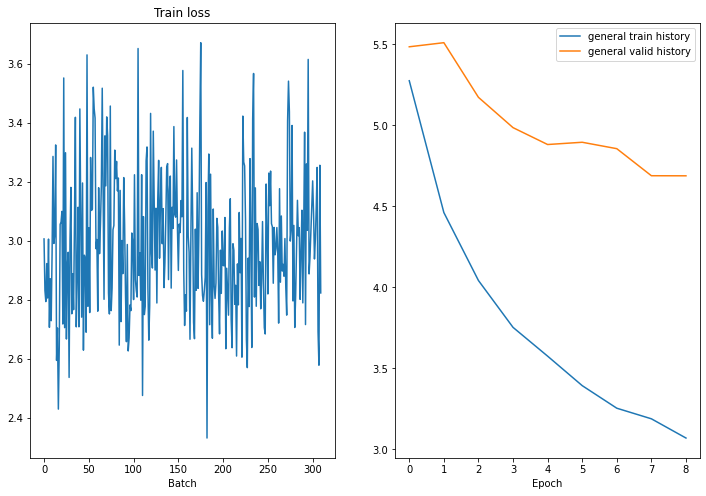

Epoch: 10 | Time: 1m 6s
	Train Loss: 2.994 | Train PPL:  19.962
	 Val. Loss: 4.700 |  Val. PPL: 109.998


In [ ]:
run_training(model, train_iterator, valid_iterator,
             optimizer, criterion, clip=CLIP, n_epochs=N_EPOCHS)

In [ ]:
print("Translation examples")
utils.get_translation_sample(model, TRG.vocab, test_iterator, cnt=5)
print("BLUE score", utils.corpus_blue_accuracy(model, TRG.vocab, test_iterator))

3it [00:00, 28.27it/s]

Translation examples
Original: a ski school is right next door .
Generated: the beach .

Original: on site parking is possible .
Generated: the property .

Original: all units are functionally furnished .
Generated: rooms rooms come with a tv .

Original: you will find a 24 - hour front desk at the property .
Generated: a 24 - hour front desk .

Original: free wifi access is available .
Generated: free wifi access .



59it [00:03, 18.20it/s]


BLUE score 13.446034988299033


### Experiment 1: FastText embeddings

Используем предобученные эмбединги (RU -- из DeepPavlov, EN -- встроенный в torch)

In [ ]:
EXP_NAME = "exp_1_pretr_embs"
PAD_IDX = TRG.vocab.stoi['<pad>']
BATCH_SIZE = 128
N_EPOCHS = 10
CLIP = 1

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    sort_key=(lambda x : len(x.src)),
    batch_size = BATCH_SIZE, 
    device = device,
)

print(f'Experiment: {EXP_NAME}')
model = construct_nmt_model(device, EXP_NAME, SRC.vocab, TRG.vocab, use_emb_weights=True)
print(f'The model has {network.count_parameters(model):,} trainable parameters')

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

Experiment: exp_1_pretr_embs
Set pretrained weights for encoder.embedding.weight
Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.3669,  0.2065, -0.0850,  ...,  0.2203,  0.2614,  0.1908],
        [ 0.2997,  0.1305,  0.1509,  ...,  0.0792,  0.2127,  0.1059],
        [-0.5025, -0.4536, -0.1124,  ...,  0.2959, -0.2153, -0.1890]],
       device='cuda:0', requires_grad=True)
Set pretrained weights for decoder.embedding.weight
Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3572, -0.0841,  0.2360,  ..., -0.1437,  

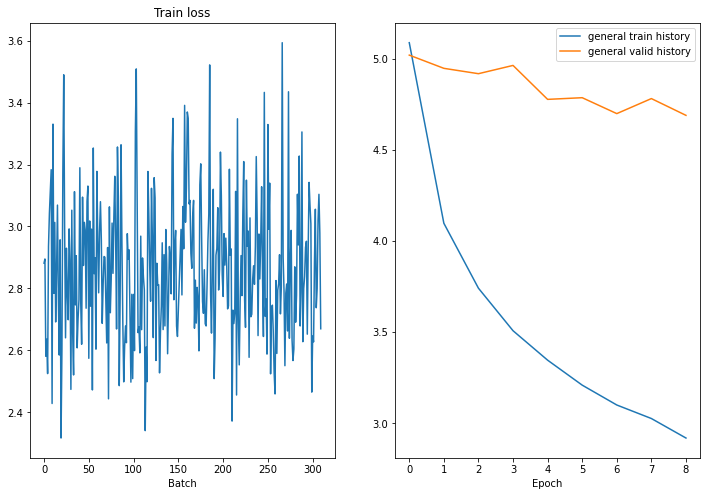

Epoch: 10 | Time: 1m 6s
	Train Loss: 2.862 | Train PPL:  17.500
	 Val. Loss: 4.699 |  Val. PPL: 109.807


In [ ]:
run_training(model, train_iterator, valid_iterator,
             optimizer, criterion, clip=CLIP, n_epochs=N_EPOCHS)

In [ ]:
print("Translation examples")
utils.get_translation_sample(model, TRG.vocab, test_iterator, cnt=5)
print("BLUE score", utils.corpus_blue_accuracy(model, TRG.vocab, test_iterator))

3it [00:00, 26.92it/s]

Translation examples
Original: a ski school is right next door .
Generated: ski ski area is just metres metres away .

Original: on site parking is possible .
Generated: free parking .

Original: all units are functionally furnished .
Generated: all rooms with a private bathroom .

Original: you will find a 24 - hour front desk at the property .
Generated: 24 - hour front desk and a . .

Original: free wifi access is available .
Generated: free wifi access .



59it [00:03, 18.12it/s]


BLUE score 16.061950217095955
